# Don't Overfit! II EDA + ML

![](https://www.apixio.com/wp-content/uploads/2017/10/classification-with-overfitting-2.png)
[image-source](https://www.apixio.com/wp-content/uploads/2017/10/classification-with-overfitting-2.png)

In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import gc

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


## Exploratory Data Analysis

In [39]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [40]:
train.shape, test.shape

((250, 302), (19750, 301))

In [41]:
train.columns

Index(['id', 'target', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '290', '291', '292', '293', '294', '295', '296', '297', '298', '299'],
      dtype='object', length=302)

In [42]:
train.target.value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [43]:
train.target.value_counts() / len(train)

1.0    0.64
0.0    0.36
Name: target, dtype: float64

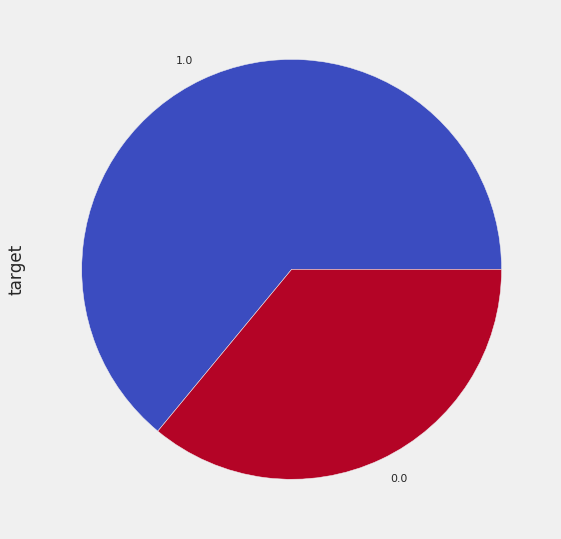

In [44]:
train['target'].value_counts().plot(kind="pie", figsize=(12,9), colormap="coolwarm")

In [45]:
train.isna().sum().sum()

0

In [46]:
test.isna().sum().sum()

0

In [47]:
train.describe()

id      target     ...             298         299
count  250.000000  250.000000     ...      250.000000  250.000000
mean   124.500000    0.640000     ...        0.009372   -0.128952
std     72.312977    0.480963     ...        1.008099    0.971219
min      0.000000    0.000000     ...       -3.211000   -3.500000
25%     62.250000    0.000000     ...       -0.550000   -0.754250
50%    124.500000    1.000000     ...       -0.009000   -0.132500
75%    186.750000    1.000000     ...        0.654250    0.503250
max    249.000000    1.000000     ...        3.530000    2.771000

[8 rows x 302 columns]

In [48]:
numerical_features = train.columns[2:]

Distributions columns


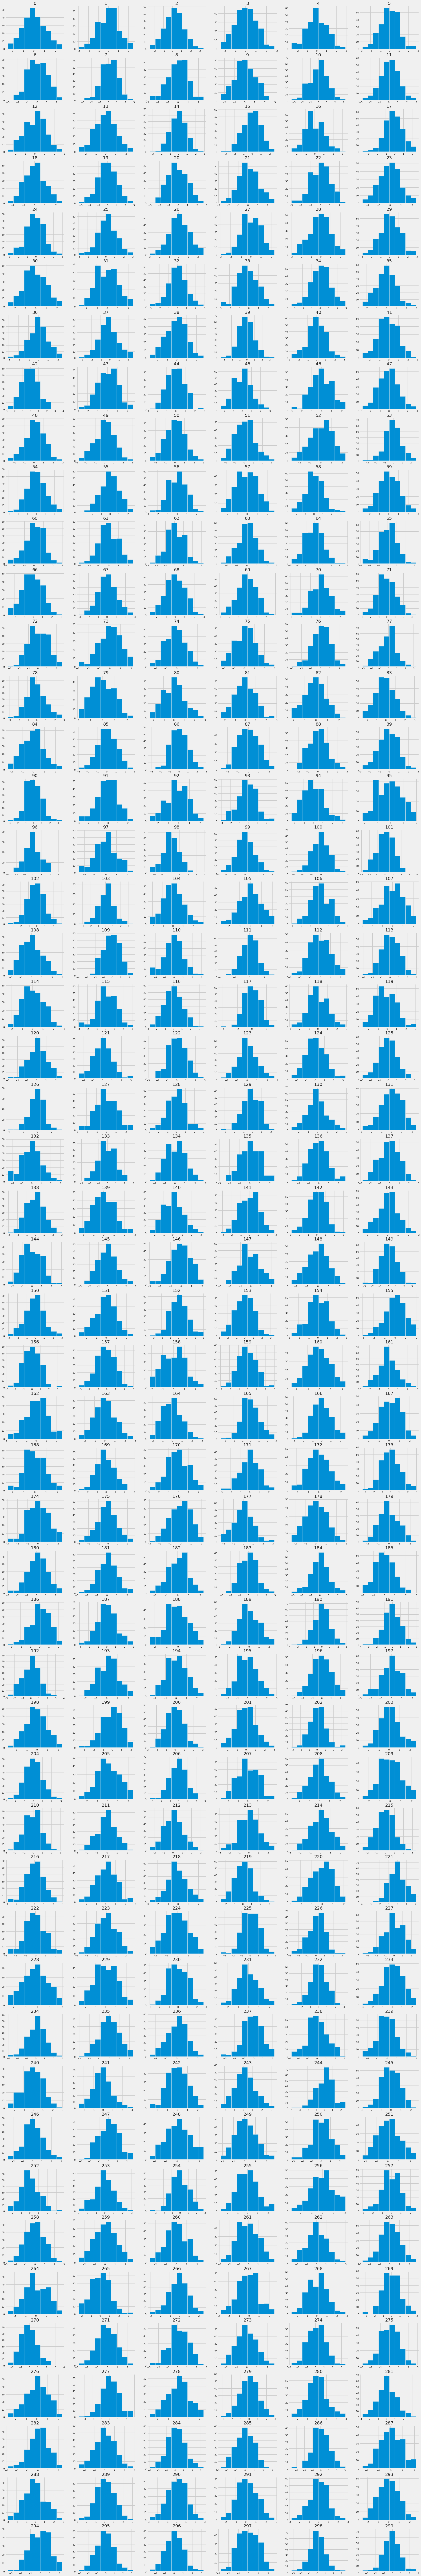

In [49]:
print('Distributions columns')
plt.figure(figsize=(30, 200))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 6, i + 1)
    plt.hist(train[col]) 
    plt.title(col)
gc.collect();

Distributions columns


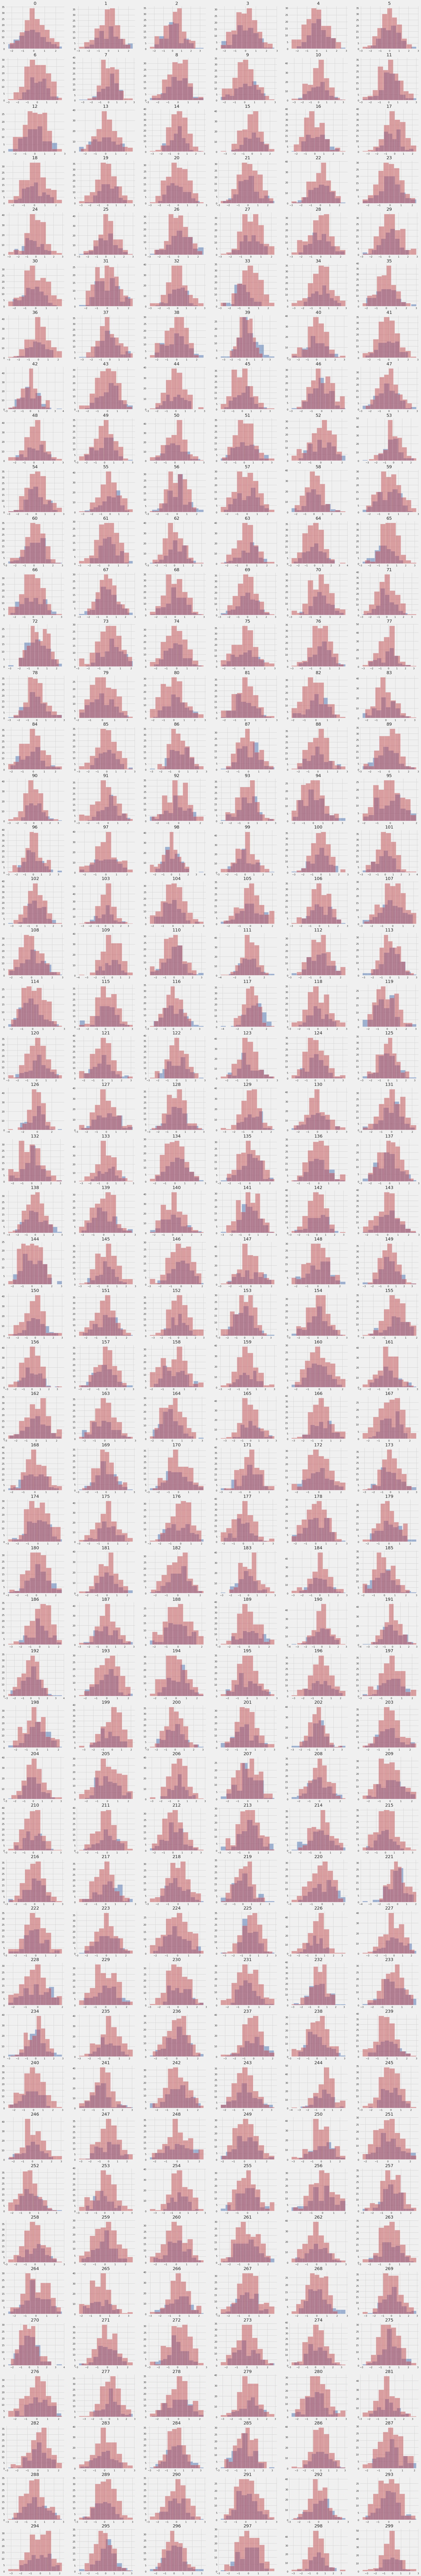

In [50]:
print('Distributions columns')
plt.figure(figsize=(30, 200))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 6, i + 1)
    plt.hist(train[train["target"] == 0][col], alpha=0.5, label='0', color='b')
    plt.hist(train[train["target"] == 1][col], alpha=0.5, label='1', color='r')    
    plt.title(col)
gc.collect();

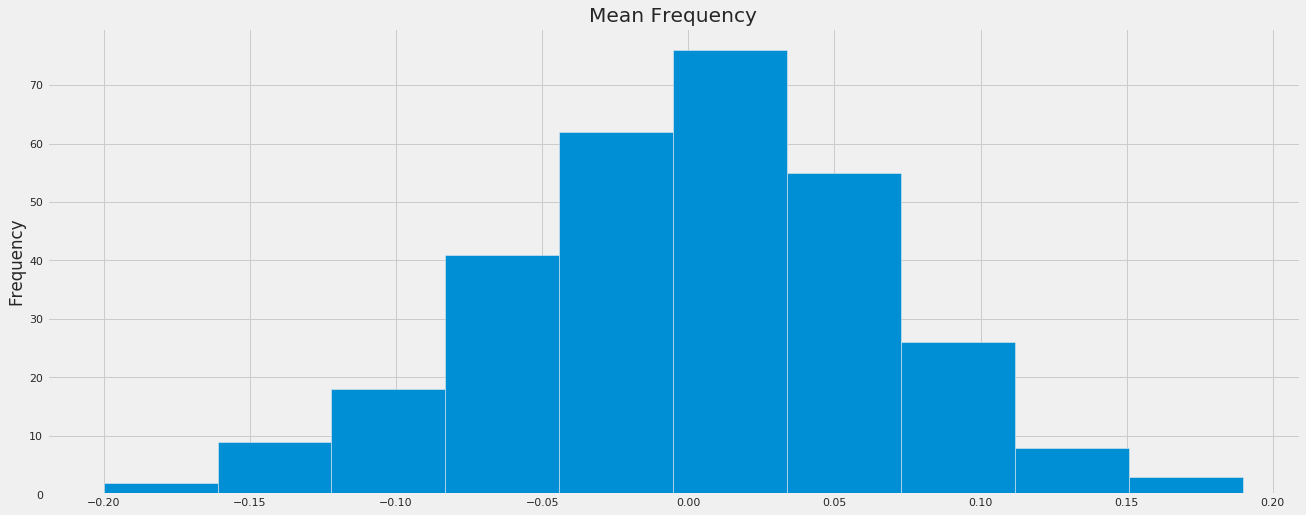

In [51]:
plt.figure(figsize=(20, 8))
train[numerical_features].mean().plot('hist');
plt.title('Mean Frequency');

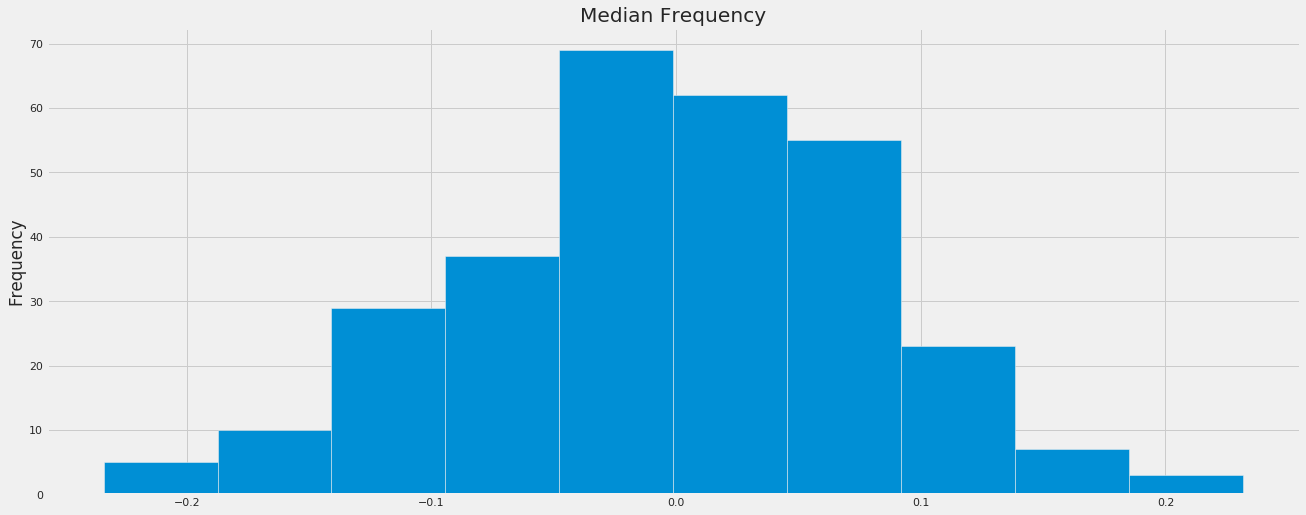

In [52]:
plt.figure(figsize=(20, 8))
train[numerical_features].median().plot('hist');
plt.title('Median Frequency');

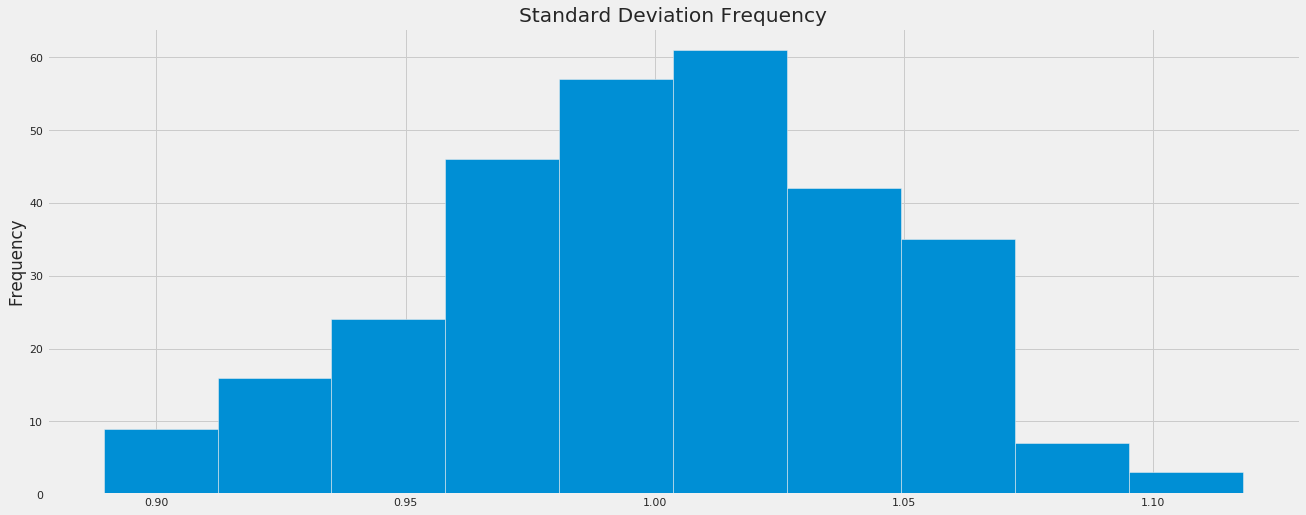

In [53]:
plt.figure(figsize=(20, 8))
train[numerical_features].std().plot('hist');
plt.title('Standard Deviation Frequency');

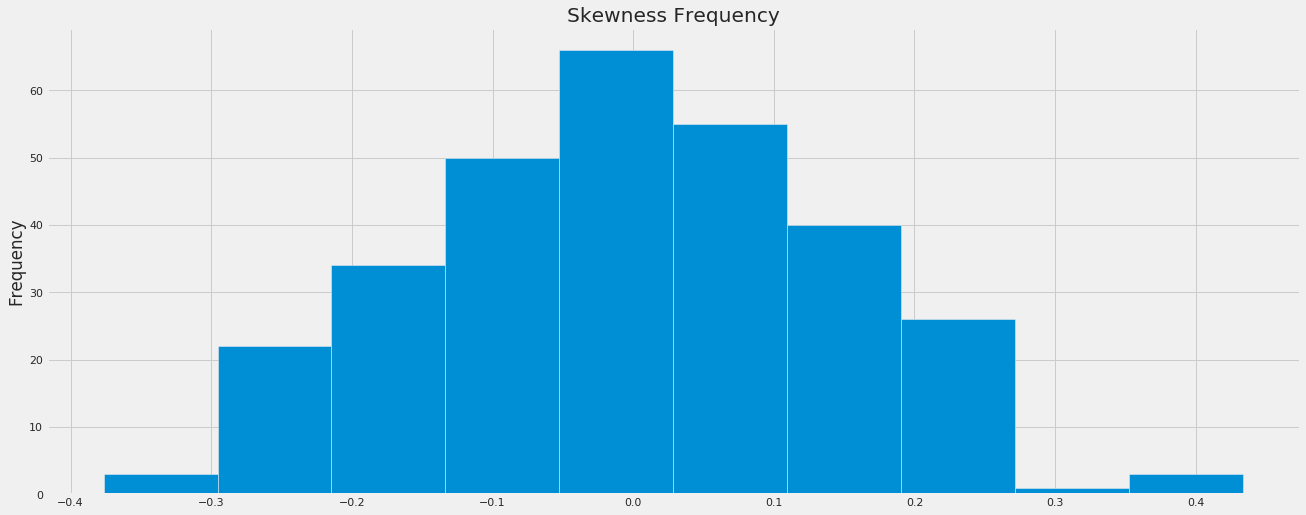

In [54]:
plt.figure(figsize=(20, 8))
train[numerical_features].skew().plot('hist');
plt.title('Skewness Frequency');

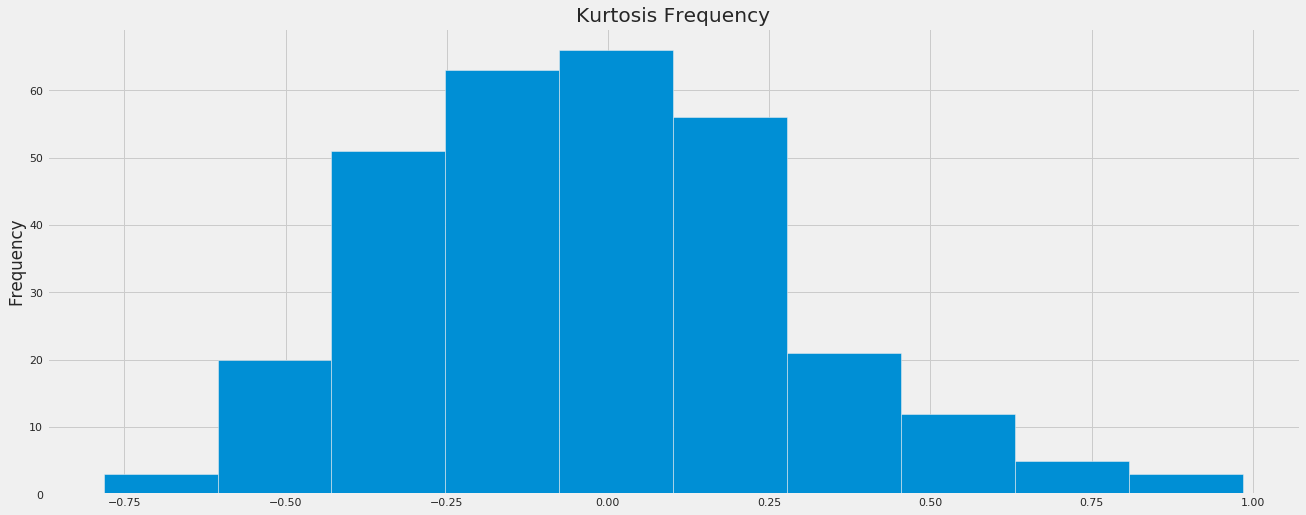

In [55]:
plt.figure(figsize=(20, 8))
train[numerical_features].kurt().plot('hist');
plt.title('Kurtosis Frequency');

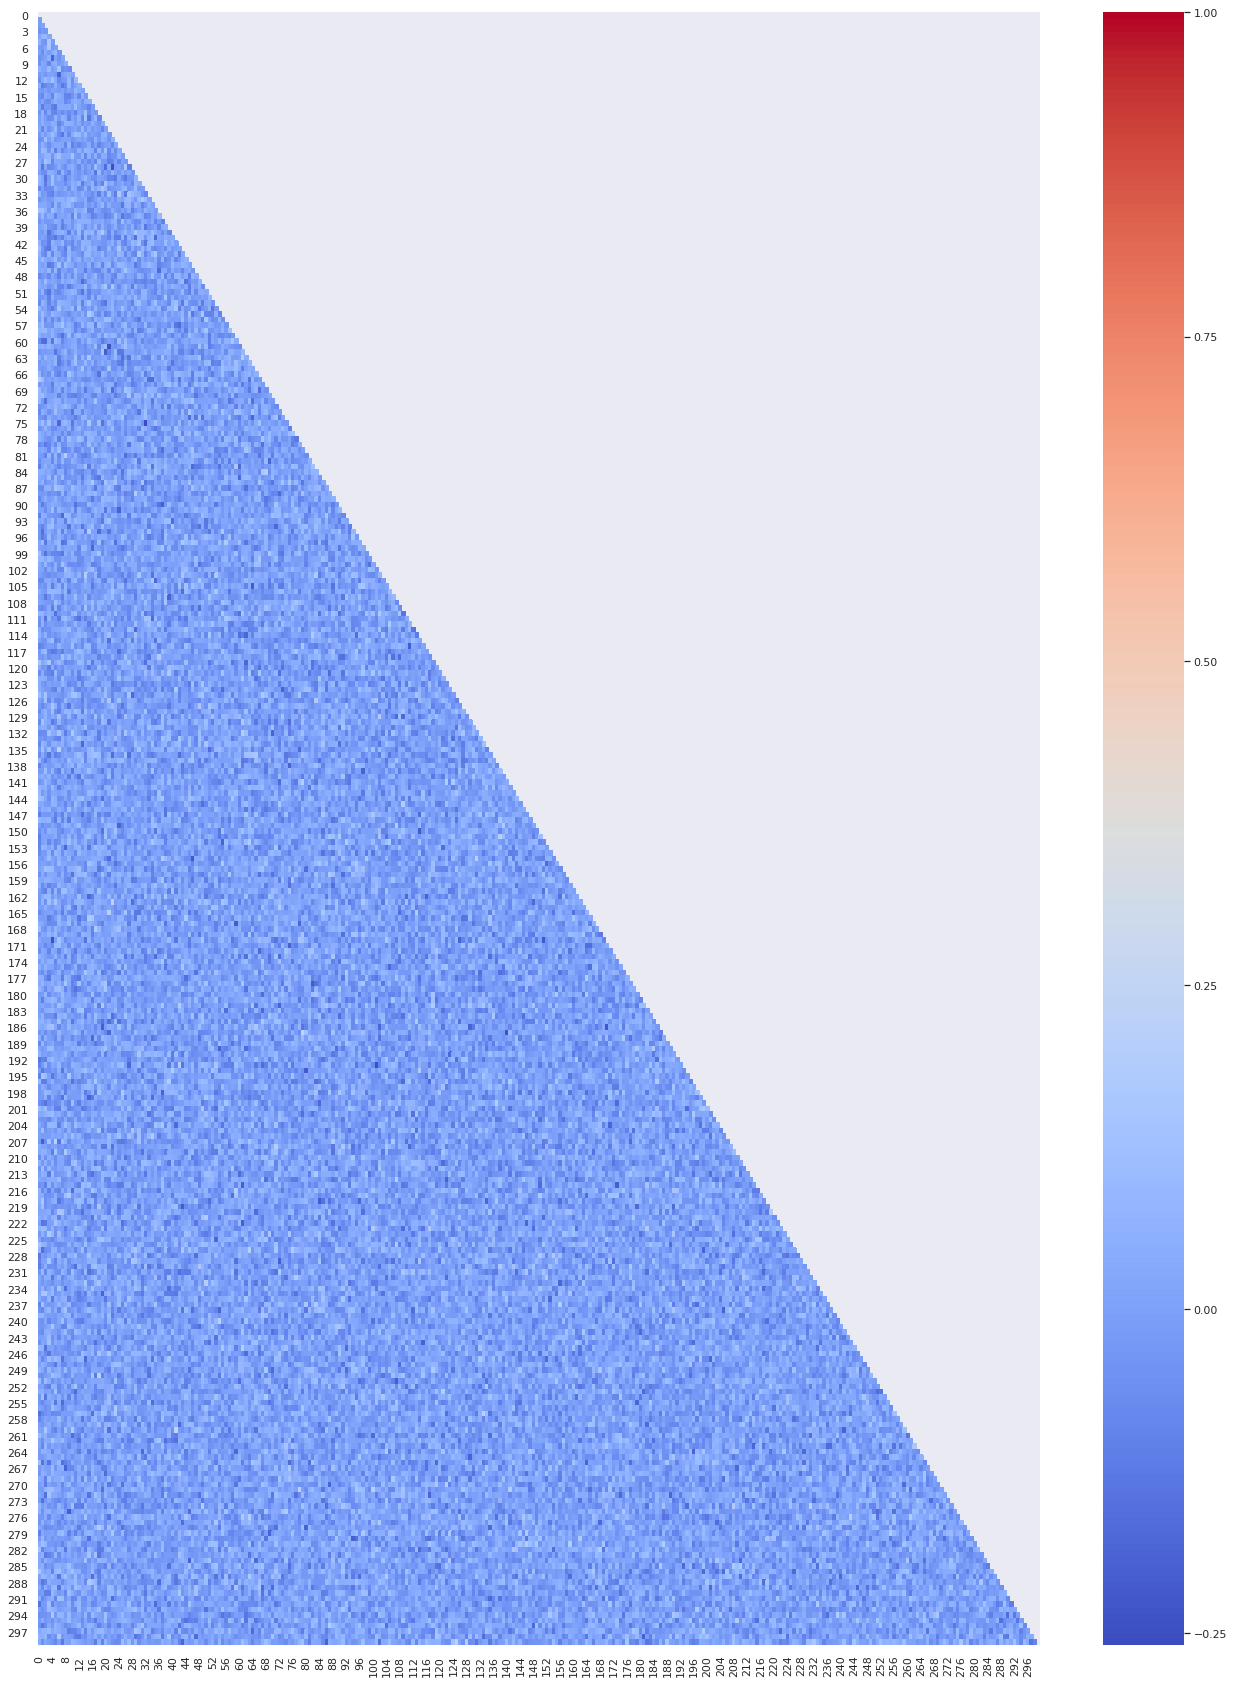

In [56]:
sns.set(rc={'figure.figsize':(20,28)})

# Compute the correlation matrix
corr = train[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            #annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

In [57]:
s = corr.unstack().drop_duplicates()
so = s.sort_values(kind="quicksort")
so = so.drop_duplicates()

print("Top most highly positive correlated features:")
print(so[(so<1) & (so>0.2)].sort_values(ascending=False))

print()

print("Top most highly megative correlated features:")
print(so[(so < - 0.2)])

Top most highly positive correlated features:
79   187    0.243916
41   260    0.242902
22   163    0.236516
18   250    0.233152
5    207    0.226966
125  299    0.224052
78   271    0.222923
133  257    0.221418
6    135    0.216808
131  155    0.216209
21   165    0.213463
231  274    0.213213
243  276    0.212386
138  151    0.211722
54   240    0.210084
100  271    0.209413
63   227    0.207998
61   63     0.207553
87   296    0.207524
61   132    0.207165
137  200    0.206929
107  214    0.206226
8    81     0.205368
122  270    0.205286
50   233    0.205262
63   276    0.203690
0    67     0.202806
141  271    0.202313
71   208    0.202069
102  129    0.201321
61   245    0.201165
128  299    0.200844
156  237    0.200710
42   193    0.200387
dtype: float64

Top most highly megative correlated features:
32   75    -0.259315
101  193   -0.252825
22   28    -0.246062
140  187   -0.244012
4    170   -0.242965
21   61    -0.241085
151  170   -0.227826
170  186   -0.226870
46   155  

## Machine Learning Modeling

In [58]:
train.shape, test.shape

((250, 302), (19750, 301))

In [59]:
# special thanks to https://www.kaggle.com/gpreda/santander-eda-and-prediction
# also big help for feature engineering :https://www.kaggle.com/hjd810/keras-lgbm-aug-feature-eng-sampling-prediction
# last but not least: https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/87486#latest-506429

fs_params = dict()
fs_params["descriptives"] = True
fs_params["standardization"] = True
fs_params["percentiles"] = False
fs_params["squared"] = True
fs_params["frequency"] = True

gc.collect();
turn = 0
from sklearn.preprocessing import StandardScaler
for df in [test, train]:
    
    
    if turn == 0:
        print("Train set")
        turn = 1
    else:
        print("Test set")
    
    if (fs_params["descriptives"] == True):
        print('\t*descriptive statistics Feature Engineering:')
        df['sum'] = df[numerical_features].sum(axis=1)  
        df['min'] = df[numerical_features].min(axis=1)
        df['max'] = df[numerical_features].max(axis=1)
        df['mean'] = df[numerical_features].mean(axis=1)
        df['std'] = df[numerical_features].std(axis=1)
        df['skew'] = df[numerical_features].skew(axis=1)
        df['kurt'] = df[numerical_features].kurtosis(axis=1)
        df['med'] = df[numerical_features].median(axis=1)
        print('\t*descriptive statistics Feature Engineering done!')
    
    if (fs_params["standardization"] == True):
        print('\t*Standardizing the data:')
        #inf values can result from squaring
        scaler = StandardScaler()
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
        print('\t*Data Standardized!')
    
    if (fs_params["percentiles"] == True):
        print('\t*percentiles Feature Engineering:')
        perc_list = [1,2,5,10,25,50,60,75,80,85,95,99]
        for i in perc_list:
            df['perc_'+str(i)] =  df[numerical_features].apply(lambda x: np.percentile(x, i), axis=1)
        print('\t*Done percentiles Feature Engineering!')
    
    if (fs_params["squared"] == True):
        print('\t*Loading Squared data:')
        for i in numerical_features:
            df['var_sq_'+str(i)] = np.square(df[str(i)])
        print('\t*Done squaring!')
    
    if (fs_params["frequency"] == True):
        #thanks to  https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/87486#latest-506429
        print('\t*Loading frequency:')
        for var in numerical_features:
            hist, bin_edges = np.histogram(df[var], bins=1000, density=True)
            df['hist_'+var] = [ hist[np.searchsorted(bin_edges,ele)-1] for ele in df[var]]
        print('\t*Done Loading frequency!')
    
gc.collect();

Train set
	*descriptive statistics Feature Engineering:
	*descriptive statistics Feature Engineering done!
	*Standardizing the data:
	*Data Standardized!
	*Loading Squared data:
	*Done squaring!
	*Loading frequency:
	*Done Loading frequency!
Test set
	*descriptive statistics Feature Engineering:
	*descriptive statistics Feature Engineering done!
	*Standardizing the data:
	*Data Standardized!
	*Loading Squared data:
	*Done squaring!
	*Loading frequency:
	*Done Loading frequency!


In [60]:
train.columns

Index(['id', 'target', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       'hist_290', 'hist_291', 'hist_292', 'hist_293', 'hist_294', 'hist_295',
       'hist_296', 'hist_297', 'hist_298', 'hist_299'],
      dtype='object', length=910)

In [61]:
train.head(6)

id  target         0    ...     hist_297  hist_298  hist_299
0   0     1.0 -0.121736    ...     0.738233  0.596992  1.854775
1   1     0.0  1.061577    ...     0.738233  1.193984  0.618258
2   2     1.0 -0.548290    ...     1.476466  0.596992  0.618258
3   3     1.0  0.043868    ...     2.214699  0.596992  1.236517
4   4     1.0  2.332208    ...     0.738233  0.596992  0.618258
5   5     1.0 -0.666722    ...     0.738233  0.596992  1.236517

[6 rows x 910 columns]

In [62]:
test.shape

(19750, 909)

In [63]:
train.shape, test.shape

((250, 910), (19750, 909))

In [64]:
y = train['target']
X = train.drop(['target', "id"], axis=1)

In [65]:
clf_stats_df = pd.DataFrame(columns=["clf_name", "F1-score", "auc-score"])

### Baseline Modeling
<a id="base"></a>

In [66]:
def xgboost_all_purpose(X, y, type_of_training, name, num_of_folds=3, params=None, in_folds_sampling = False, max_early_stopping = 100):
    
    ####
    #
    # This is an all purpose xgboost function for all balanced, imbalanced and resampling cases
    # please excuse me for its length
    #
    ####
    
    
    from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
    from collections import Counter
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import time
    import random
    
    import xgboost as xgb
    
    global clf_stats_df
    
    if params is None:
        params = dict()
        params["learning_rate"] = 0.1
        params["n_estimators"] = 1000
        params["max_depth"] = 2
        params["min_child_weight"] = 1
        params["gamma"] = 0
        params["subsample"] = 1
        params["colsample_bytree"] = 1
        params["colsample_bylevel"] = 1
        params["reg_alpha"] = 0
        params["reg_lambda"] = 1
        params["scale_pos_weight"] = np.round(y.value_counts()[0] / y.value_counts()[1],3)
        params["max_delta_step"] = 1
    
    print("params", params)
    print("max_early_stopping:", max_early_stopping)
    
    if type_of_training == "baseline":
        
        print("baseline")
        
        # create a 70/30 stratified split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)
    
        import xgboost as xgb

        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]
            
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()
            
            clf_stra_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    colsample_bylevel=params["colsample_bylevel"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

            clf_stra_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                        early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_stra_xgb.predict(xvalid)
            predictions_probas = clf_stra_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds
            
            predictions_test += clf_stra_xgb.predict_proba(test.drop("id", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas_list[:,1], average = "macro"))
        
        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_stra_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)
        
        print()
        gc.collect();
        return clf_stra_xgb, predictions_test

    
    elif type_of_training == "oversampling":
        
        print("oversampling")
        #### resampling techniques:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

        # RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)
        
        from collections import Counter
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled
        del X_resampled
        del y_resampled
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0        

        start_time = time.time()
        
        folds = KFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain[train_index], ytrain[valid_index]
            
            print()
            print("Fold:", num_fold)
            num_fold = num_fold + 1
            print()

            clf_ros_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                        n_estimators=params["n_estimators"], 
                                        max_depth=params["max_depth"],
                                        min_child_weight=params["min_child_weight"],
                                        gamma=params["gamma"],
                                        subsample=params["subsample"],
                                        colsample_bytree=params["colsample_bytree"],
                                        colsample_bylevel=params["colsample_bylevel"],
                                        objective= 'binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=params["scale_pos_weight"],
                                        reg_alpha = params["reg_alpha"],
                                        reg_lambda = params["reg_lambda"],
                                        max_delta_step = params["max_delta_step"],
                                        seed=42)

            clf_ros_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)

            predictions = clf_ros_xgb.predict(xvalid)
            predictions_probas = clf_ros_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds  
            
            predictions_test += clf_ros_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        predictions = np.argmax(predictions_probas, axis=1)
            
        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8, 8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_ros_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        return clf_ros_xgb, predictions_test
    
    # still needs some work to work
    elif type_of_training == "smote":
        print("smote")
        #### resampling techniques, I will use Synthetic minority:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

        # SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(xtrain, ytrain)
        
        from collections import Counter
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_smote_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

        clf_smote_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)

        predictions = clf_smote_xgb.predict(xvalid)
        predictions_probas = clf_smote_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_smote_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        return clf_smote_xgb
    
    # still needs some work to work
    elif type_of_training == "undersampling":
        print("undersampling")
        #### resampling techniques:
        from imblearn.under_sampling import RandomUnderSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

        # RandomUnderSampler
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)
        
        print(sorted(Counter(y_resampled).items()))
        
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_rus_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                    n_estimators=params["n_estimators"], 
                                    max_depth=params["max_depth"],
                                    min_child_weight=params["min_child_weight"],
                                    gamma=params["gamma"],
                                    subsample=params["subsample"],
                                    colsample_bytree=params["colsample_bytree"],
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=params["scale_pos_weight"],
                                    reg_alpha = params["reg_alpha"],
                                    reg_lambda = params["reg_lambda"],
                                    max_delta_step = params["max_delta_step"],
                                    seed=42)

        clf_rus_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)

        predictions = clf_rus_xgb.predict(xvalid)
        predictions_probas = clf_rus_xgb.predict_proba(xvalid)
        
        
        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_rus_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_rus_xgb
    
    elif type_of_training == "augmentation":
        
        print("augmentation_by_fraction")
        
        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)
        
        print("ytrain target values count before augmentation:\n", sorted(Counter(ytrain).items()))
        
        #thanks to https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment
        def augment(x,y,t=2):
            xs,xn = [],[]
            for i in range(t):
                mask = y>0
                x1 = x[mask].copy()
                ids = np.arange(x1.shape[0])
                for c in range(x1.shape[1]):
                    np.random.shuffle(ids)
                    x1[:,c] = x1[ids][:,c]
                xs.append(x1)

            for i in range(t//2):
                mask = y==0
                x1 = x[mask].copy()
                ids = np.arange(x1.shape[0])
                for c in range(x1.shape[1]):
                    np.random.shuffle(ids)
                    x1[:,c] = x1[ids][:,c]
                xn.append(x1)

            xs = np.vstack(xs)
            xn = np.vstack(xn)
            ys = np.ones(xs.shape[0])
            yn = np.zeros(xn.shape[0])
            x = np.vstack([x,xs,xn])
            y = np.concatenate([y,ys,yn])
            return x,y
        
        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain[train_index], ytrain[valid_index]
            
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()
            
            X_t, ytrain_stra = augment(xtrain_stra.values, ytrain_stra.values)
            print('\tAugmentation Succeeded..')
            xtrain_stra = pd.DataFrame(X_t, columns=X.columns)
            del X_t

            clf_aug_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                        n_estimators=params["n_estimators"], 
                                        max_depth=params["max_depth"],
                                        min_child_weight=params["min_child_weight"],
                                        gamma=params["gamma"],
                                        subsample=params["subsample"],
                                        colsample_bytree=params["colsample_bytree"],
                                        colsample_bylevel=params["colsample_bylevel"],
                                        objective= 'binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=params["scale_pos_weight"],
                                        reg_alpha = params["reg_alpha"],
                                        reg_lambda = params["reg_lambda"],
                                        max_delta_step = params["max_delta_step"],
                                        seed=42)

            clf_aug_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_aug_xgb.predict(xvalid)
            predictions_probas = clf_aug_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds  
            
            predictions_test += clf_aug_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_aug_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_aug_xgb, predictions_test
    
    
    elif type_of_training == "augmentation_by_fraction":
        
        # the main idea here is to reducing the imbalance ratio from 9:1 to 3:1 without using a manual function for resampling as the previous elif statement
        print("augmentation_by_fraction")
        
        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)

        print("ytrain target values count before augmentation:\n", sorted(Counter(ytrain).items()))

        
        def augment_by_frac(xtrain, ytrain):
            
            from collections import Counter
            # Augmenting both minority and majority classes via RandomOverSampler by 3 times

            X_y = pd.DataFrame(xtrain, columns=xtrain.columns)
            X_y["target"] = ytrain
            X_y = X_y.sample(frac=3, replace=True)
            X_y.target.value_counts()
            ytrain = X_y['target']
            print("ytrain target values count after oversampling:\n",sorted(Counter(ytrain).items()))
            xtrain = X_y.drop(['target'], axis=1)
            del X_y

            from imblearn.under_sampling import RandomUnderSampler

            # reducing the majority class almost back to its original form
            rus = RandomUnderSampler(sampling_strategy=0.33, random_state=42)
            X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)

            print("ytrain target values count after Augmentation:\n",sorted(Counter(y_resampled).items()))

            xtrain=pd.DataFrame(X_resampled, columns = xtrain.columns)
            ytrain = y_resampled

            del X_resampled
            del y_resampled

            return xtrain, ytrain
        
        
        if in_folds_sampling == False:
            print("augmentation before stratification")
            xtrain, ytrain = augment_by_frac(xtrain, ytrain)

        start_time = time.time()
        
        predictions_probas_list = np.zeros([len(yvalid), 2])
        predictions_test = np.zeros(len(test))
        num_fold = 0
        #feature_importance_df = pd.DataFrame()
        
        folds = StratifiedKFold(n_splits=num_of_folds, shuffle=False, random_state = 42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain[train_index], ytrain[valid_index]
                        
            print()
            print("Stratified Fold:", num_fold)
            num_fold = num_fold + 1
            print()
            
            #if in_folds_sampling is True:
            #    print("augmentation during stratification")
            #    xtrain_stra, ytrain_stra = augment_by_frac(xtrain_stra, ytrain_stra)

            clf_aug_xgb = xgb.XGBClassifier(learning_rate=params["learning_rate"], 
                                        n_estimators=params["n_estimators"], 
                                        max_depth=params["max_depth"],
                                        min_child_weight=params["min_child_weight"],
                                        gamma=params["gamma"],
                                        subsample=params["subsample"],
                                        colsample_bytree=params["colsample_bytree"],
                                        colsample_bylevel=params["colsample_bylevel"],
                                        objective= 'binary:logistic',
                                        nthread=-1,
                                        scale_pos_weight=params["scale_pos_weight"],
                                        reg_alpha = params["reg_alpha"],
                                        reg_lambda = params["reg_lambda"],
                                        max_delta_step = params["max_delta_step"],
                                        seed=42)

            clf_aug_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                    early_stopping_rounds=max_early_stopping, eval_metric='auc', verbose=100)
            
            #fold_importance_df = pd.DataFrame()
            #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
            #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_aug_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
            #fold_importance_df["fold"] = n_fold + 1
            #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions = clf_aug_xgb.predict(xvalid)
            predictions_probas = clf_aug_xgb.predict_proba(xvalid)
            predictions_probas_list += predictions_probas/num_of_folds  
            
            predictions_test += clf_aug_xgb.predict_proba(test.drop("ID_code", axis="columns")[xtrain.columns])[:,1]/num_of_folds
            
        
        predictions = np.argmax(predictions_probas, axis=1)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("CV f1_score", f1_score(yvalid, predictions, average = "macro"))
        
        print()
        print("CV roc_auc_score", roc_auc_score(yvalid, predictions_probas[:,1], average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_aug_xgb, title='Feature importance', xlabel='F score', ylabel='Features')
        
        clf_stats_df = clf_stats_df.append({"clf_name": name,
                             "F1-score":f1_score(yvalid, predictions, average = "macro"),
                             "auc-score": roc_auc_score(yvalid, predictions_probas[:,1], average = "macro")}, ignore_index=True)

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_aug_xgb, predictions_test
    
    else:
        print("Please specify for the argument 'type_of_training'one of the following parameters: (baseline, oversampling, smote, undersampling, augmentation_by_fraction)")

params {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 2, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 0.562, 'max_delta_step': 1}
max_early_stopping: 400
baseline

Stratified Fold: 0

[0]	validation_0-auc:0.882776	validation_1-auc:0.571708
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 400 rounds.
[100]	validation_0-auc:1	validation_1-auc:0.521205
[200]	validation_0-auc:1	validation_1-auc:0.55692
[300]	validation_0-auc:1	validation_1-auc:0.55692
[400]	validation_0-auc:1	validation_1-auc:0.55692
Stopping. Best iteration:
[0]	validation_0-auc:0.882776	validation_1-auc:0.571708


Stratified Fold: 1

[0]	validation_0-auc:0.823103	validation_1-auc:0.492512
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


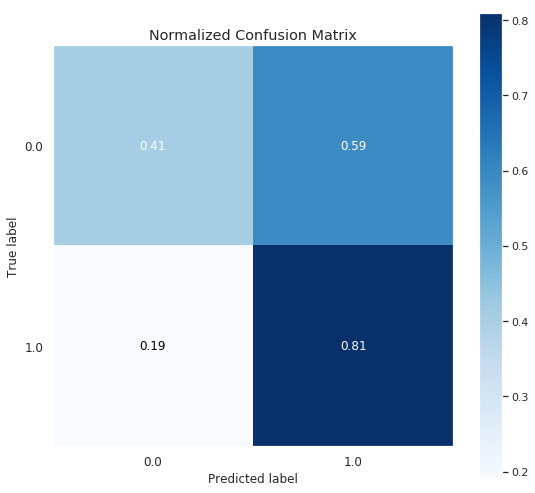

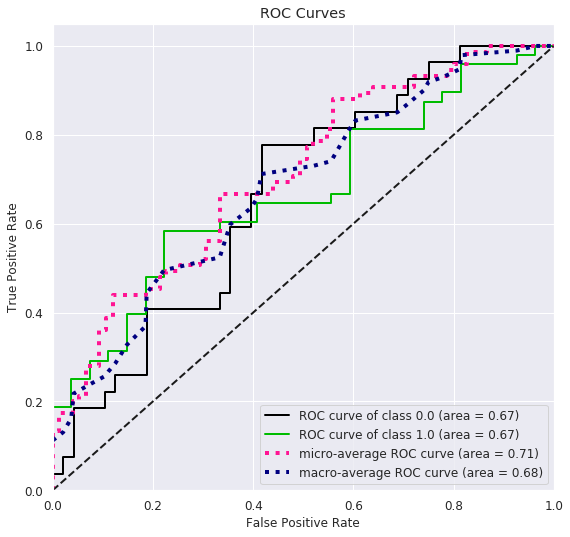

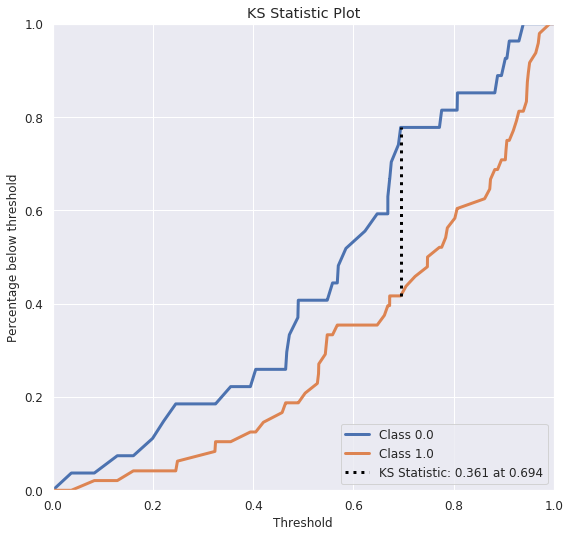

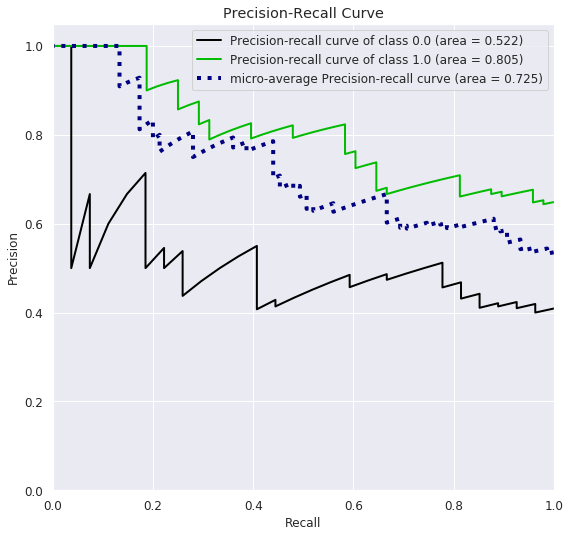

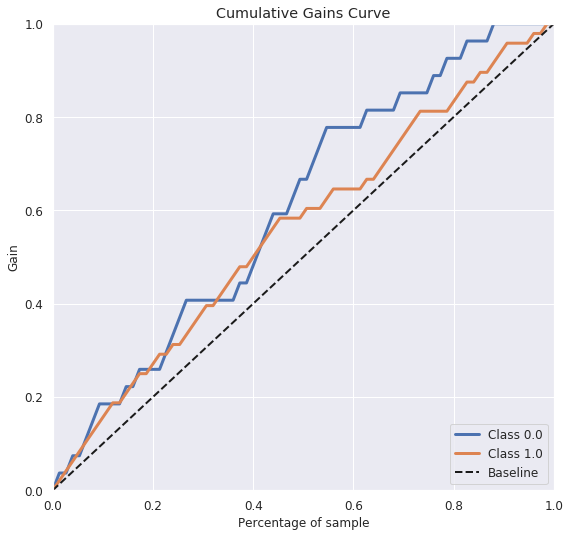

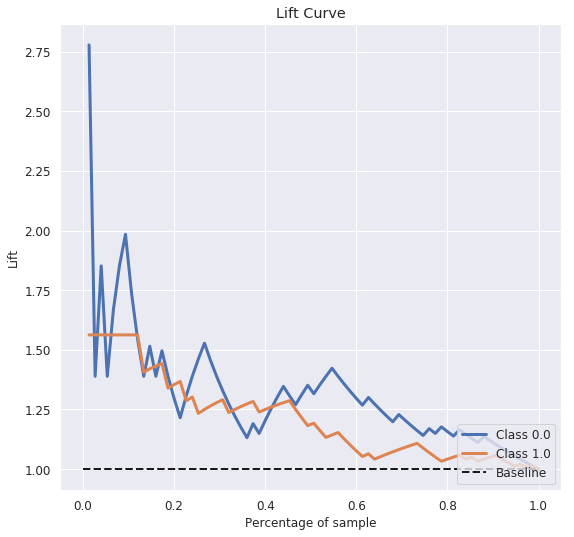

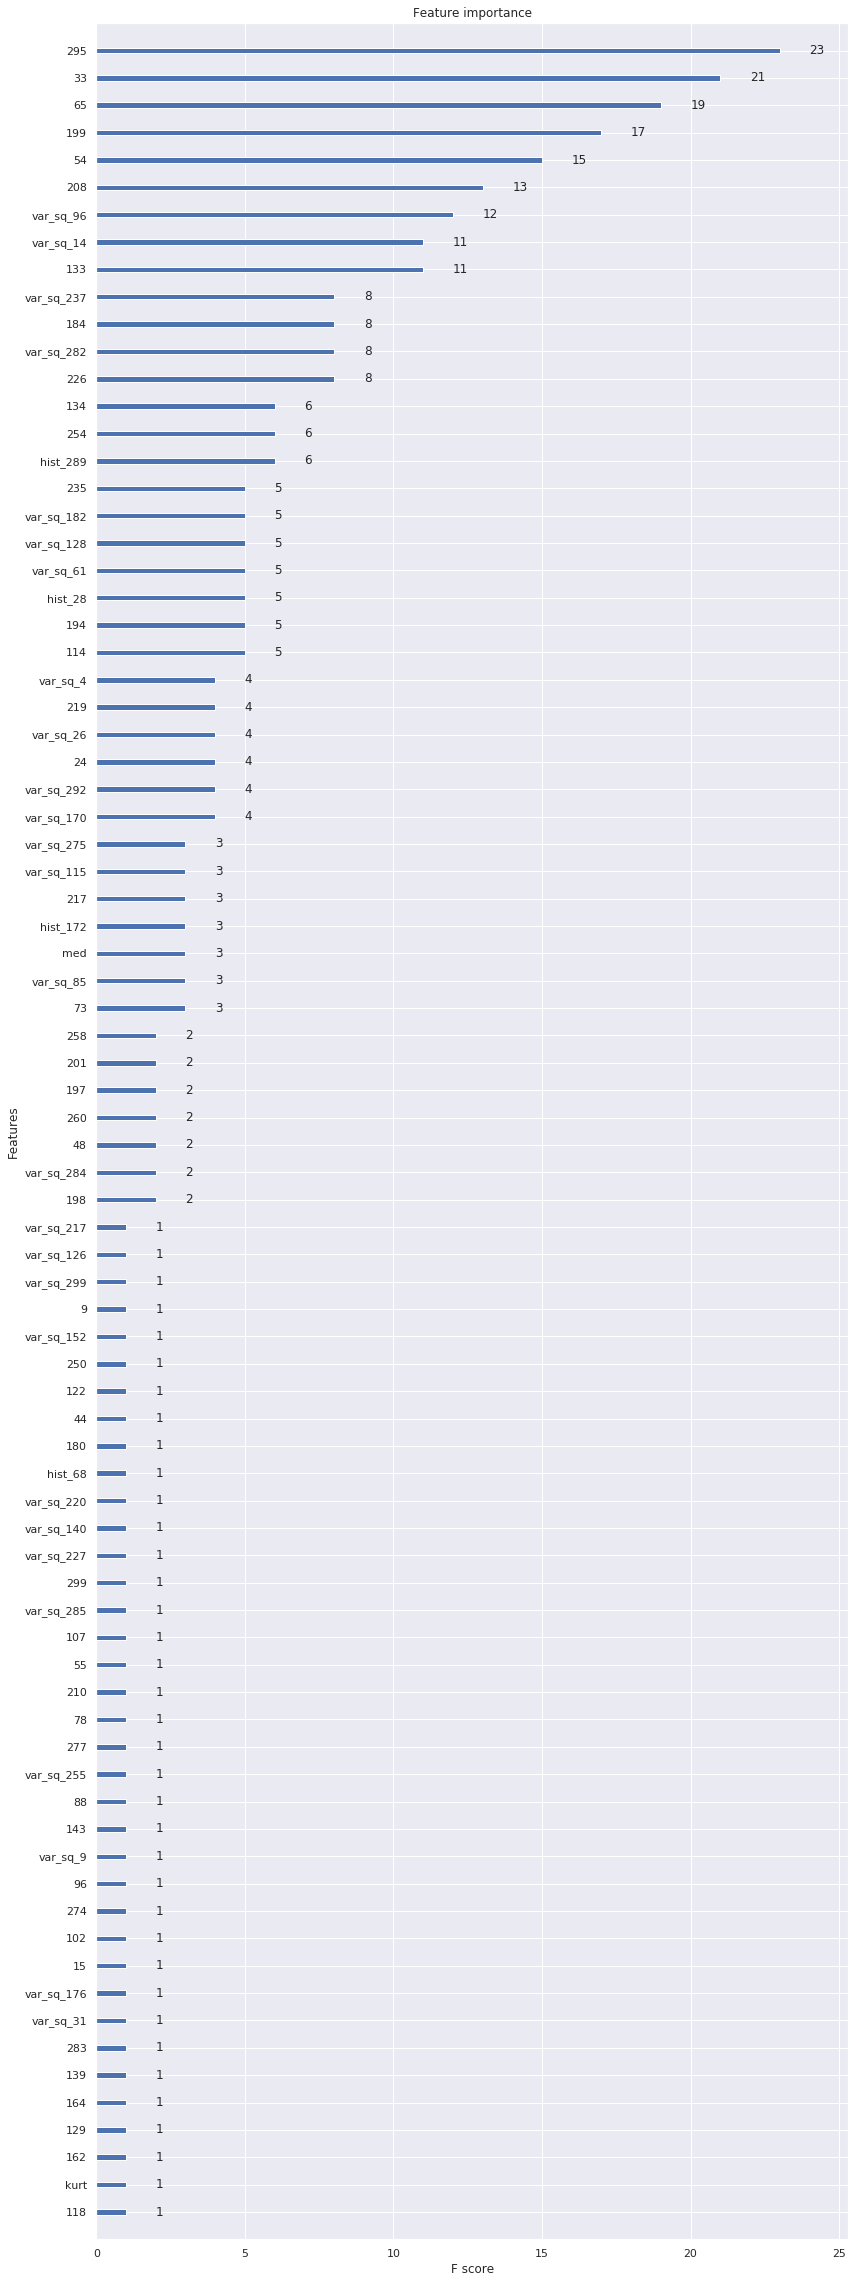

In [67]:
untuned_model_train_flag = True
type_of_training = "baseline"

if untuned_model_train_flag == True:
    
    num_of_folds = 2 ### must be more than 2
    in_folds_sampling = False

    clf_xgb, predictions_test_xgb = xgboost_all_purpose(X,y, num_of_folds = num_of_folds, 
                                                        type_of_training =type_of_training, 
                                                        in_folds_sampling = in_folds_sampling, 
                                                        max_early_stopping = 400, 
                                                        name="clf_xgb")
    
    del clf_xgb

### Feature Selection
<a id="Bayes"></a>

In [68]:
gc.collect()
feature_selection_flag = True

if feature_selection_flag == True:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier

    gc.collect();
    xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)


    rfc_model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: np.round(y.value_counts()[0] / y.value_counts()[1],3)}).fit(xtrain, ytrain)

    import eli5
    from eli5.sklearn import PermutationImportance

    perm = PermutationImportance(rfc_model, random_state=42).fit(xvalid, yvalid)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [69]:
eli5.show_weights(perm, feature_names = xvalid.columns.tolist(), top=100)

In [71]:
if feature_selection_flag == True:
    from sklearn.feature_selection import SelectFromModel

    max_selected_features = 100
    sel = SelectFromModel(perm, max_features = max_selected_features, prefit=True)

    feature_idx = sel.get_support()
    selected_feature_names = X.columns[feature_idx]

    
    X_fs_100 = X[selected_feature_names]
    print(X_fs_100.shape)
    
    max_selected_features = 50
    sel = SelectFromModel(perm, max_features = max_selected_features, prefit=True)

    feature_idx = sel.get_support()
    selected_feature_names = X.columns[feature_idx]

    
    X_fs_50 = X[selected_feature_names]
    print(X_fs_50.shape)

(250, 100)
(250, 50)


params {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 2, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 0.562, 'max_delta_step': 1}
max_early_stopping: 100
baseline

Stratified Fold: 0

[0]	validation_0-auc:0.816532	validation_1-auc:0.612165
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:1	validation_1-auc:0.609375
Stopping. Best iteration:
[1]	validation_0-auc:0.881912	validation_1-auc:0.641741


Stratified Fold: 1

[0]	validation_0-auc:0.840123	validation_1-auc:0.535714
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:1	validation_1-auc:0.636521
[200]	validation_0-auc:1	validation_1-auc:0.657258
[300]	validati

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


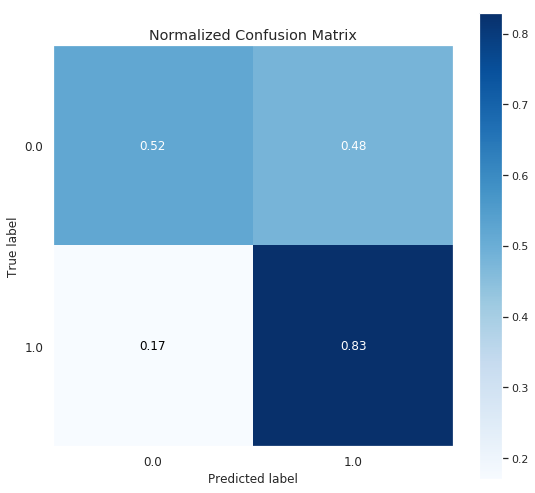

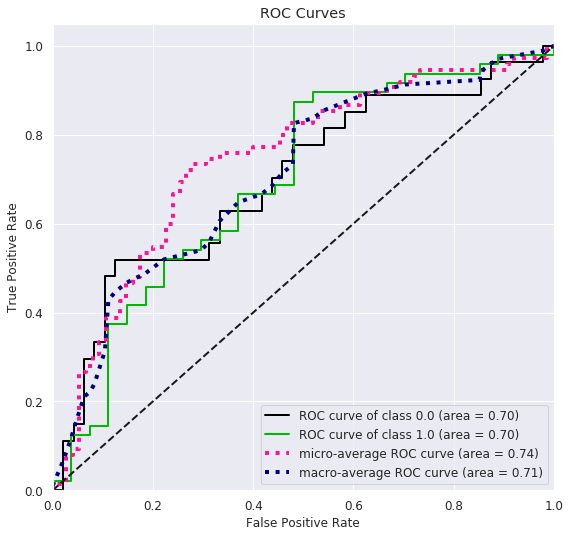

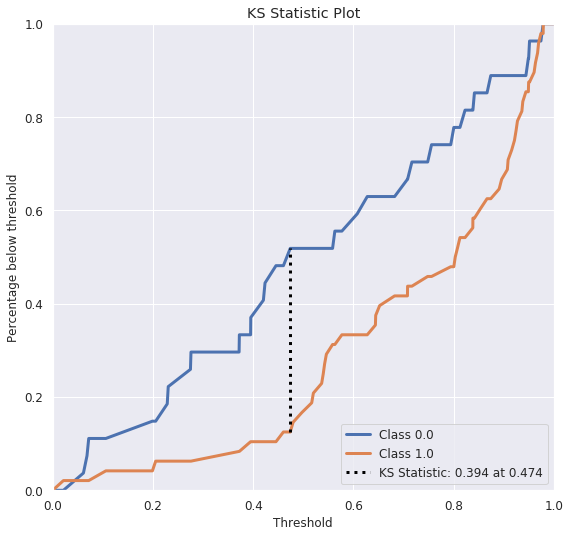

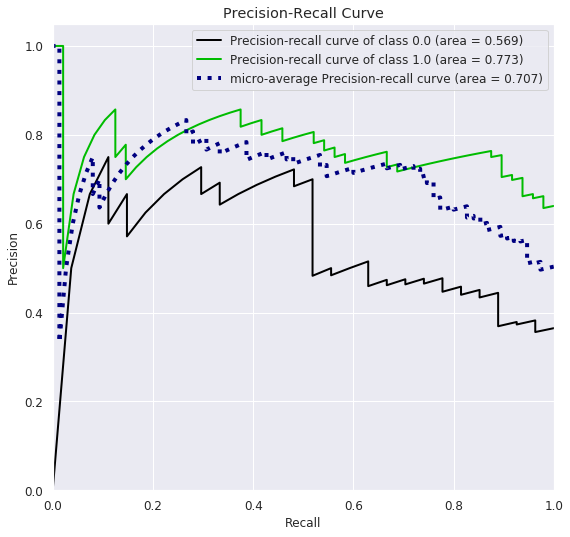

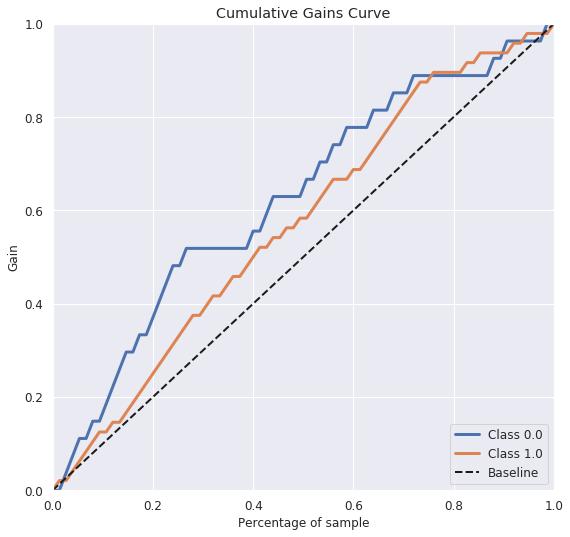

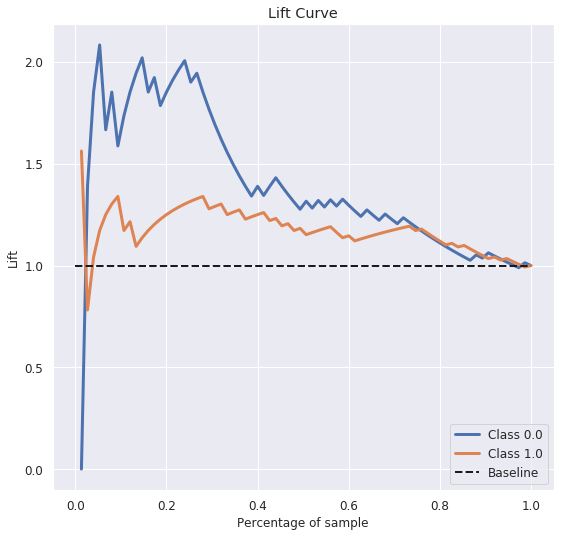

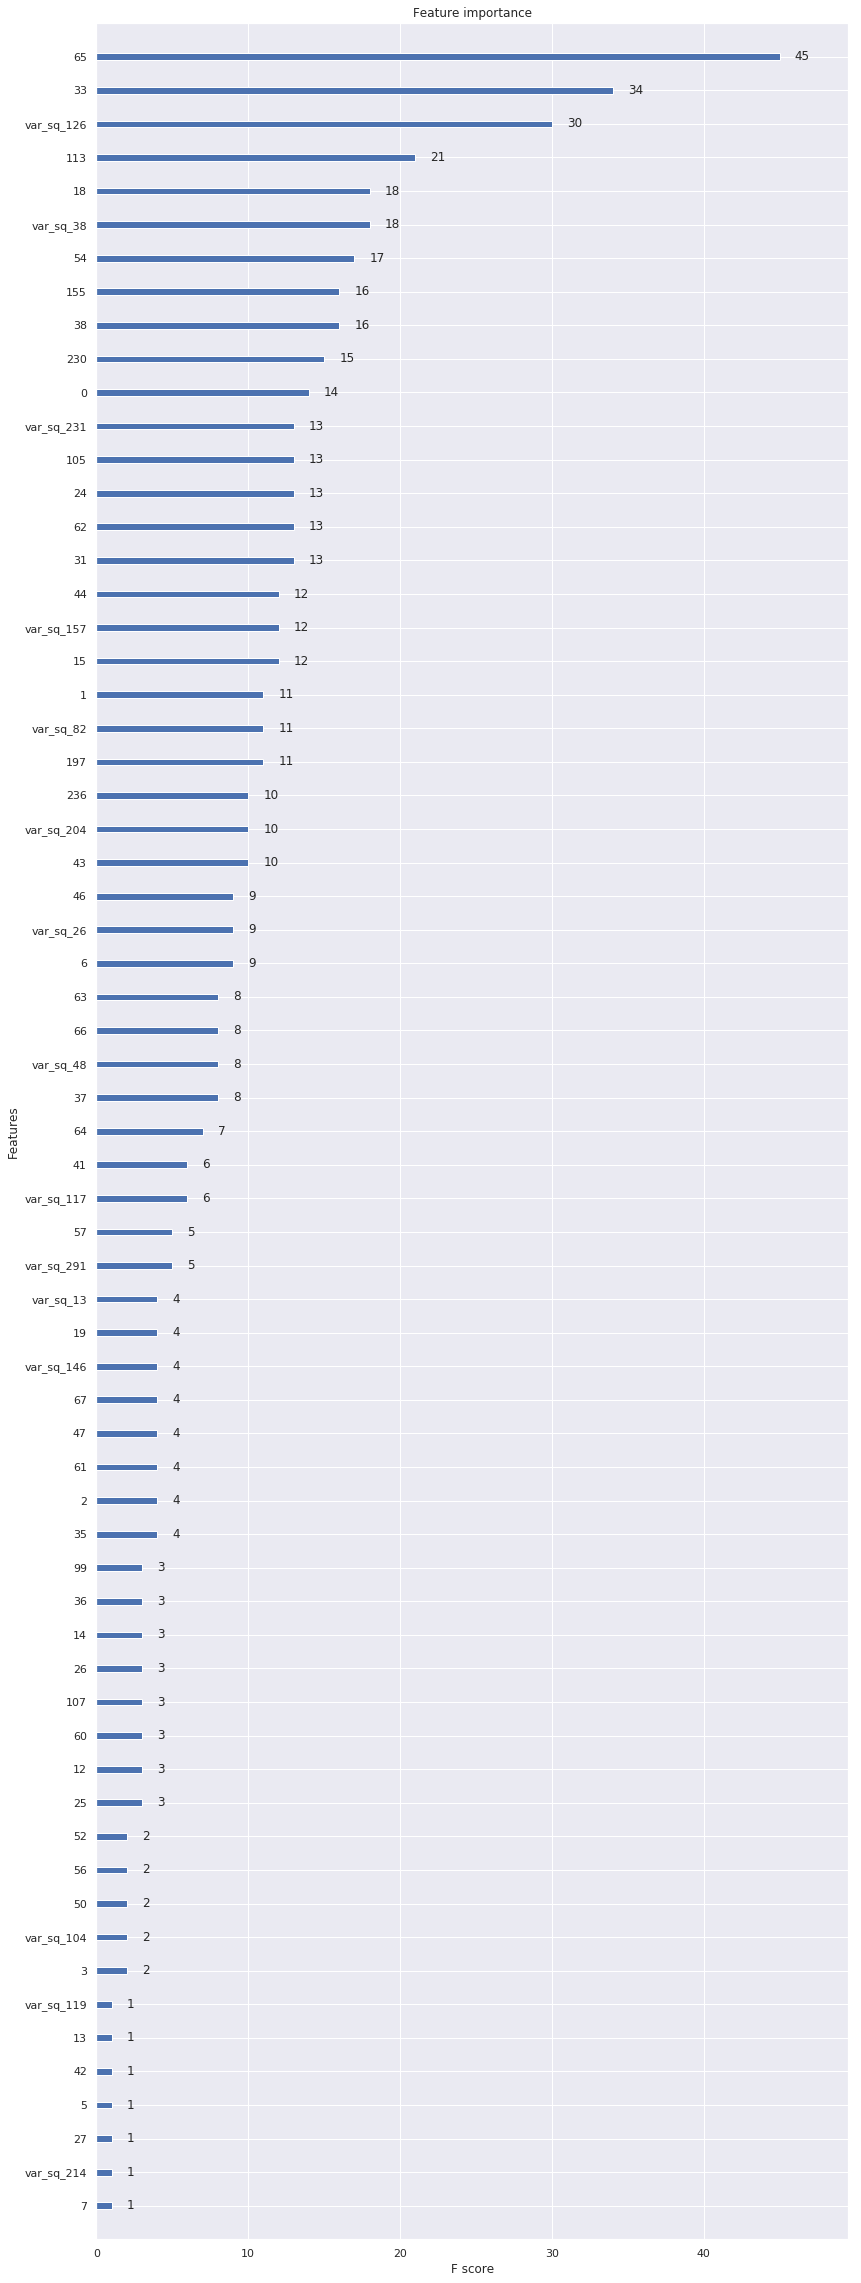

In [72]:
if feature_selection_flag == True:

    num_of_folds = 2 ### must be more than 2

    fs_clf_xgb, predictions_test_fs_100_xgb = xgboost_all_purpose(X_fs_100,
                                                              y,
                                                              type_of_training =type_of_training, 
                                                              num_of_folds = num_of_folds, 
                                                              max_early_stopping= 100, 
                                                              name="fs_clf_100_xgb")
    

params {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 2, 'min_child_weight': 1, 'gamma': 0, 'subsample': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 0.562, 'max_delta_step': 1}
max_early_stopping: 100
baseline

Stratified Fold: 0

[0]	validation_0-auc:0.816532	validation_1-auc:0.662667
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:1	validation_1-auc:0.56808
Stopping. Best iteration:
[0]	validation_0-auc:0.816532	validation_1-auc:0.662667


Stratified Fold: 1

[0]	validation_0-auc:0.790179	validation_1-auc:0.674539
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:1	validation_1-auc:0.576037
Stopping. Best iteration:
[1]	validation_0-auc:0.88644	validation_

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


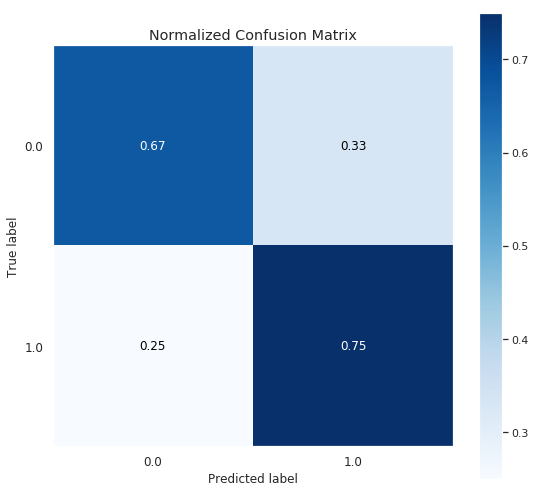

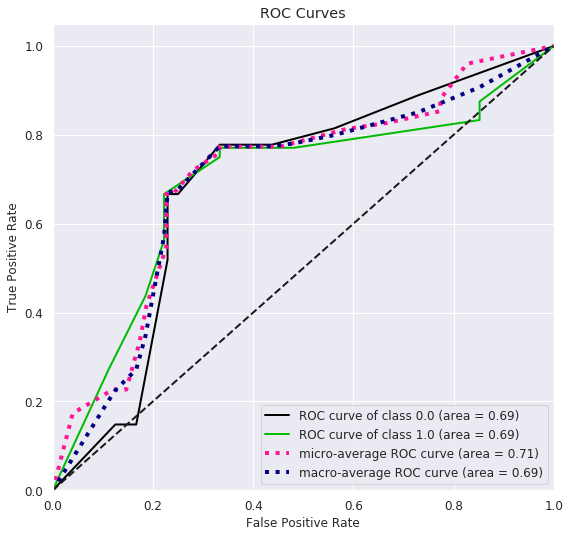

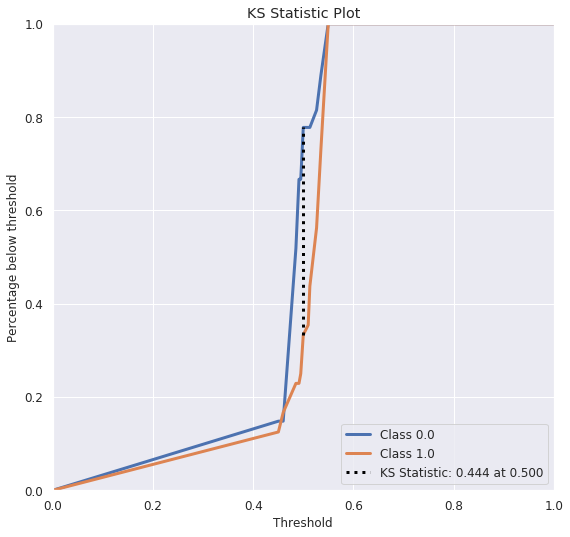

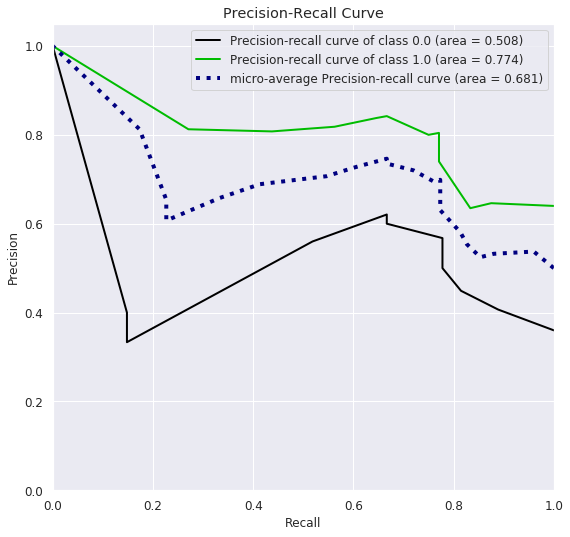

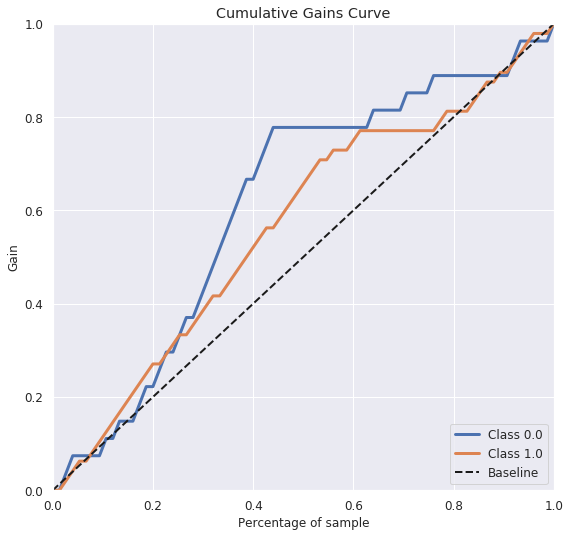

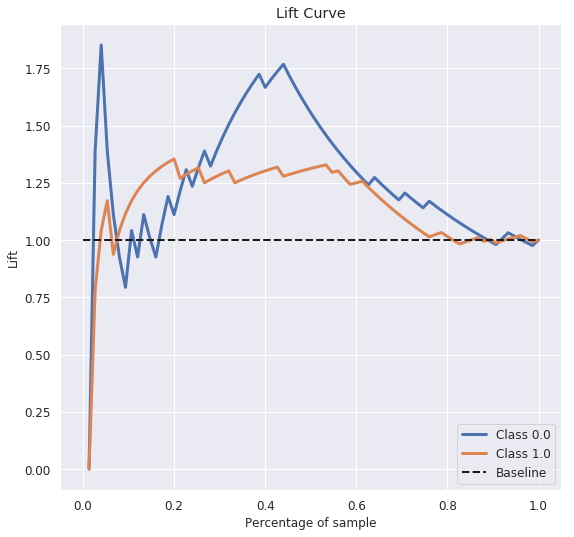

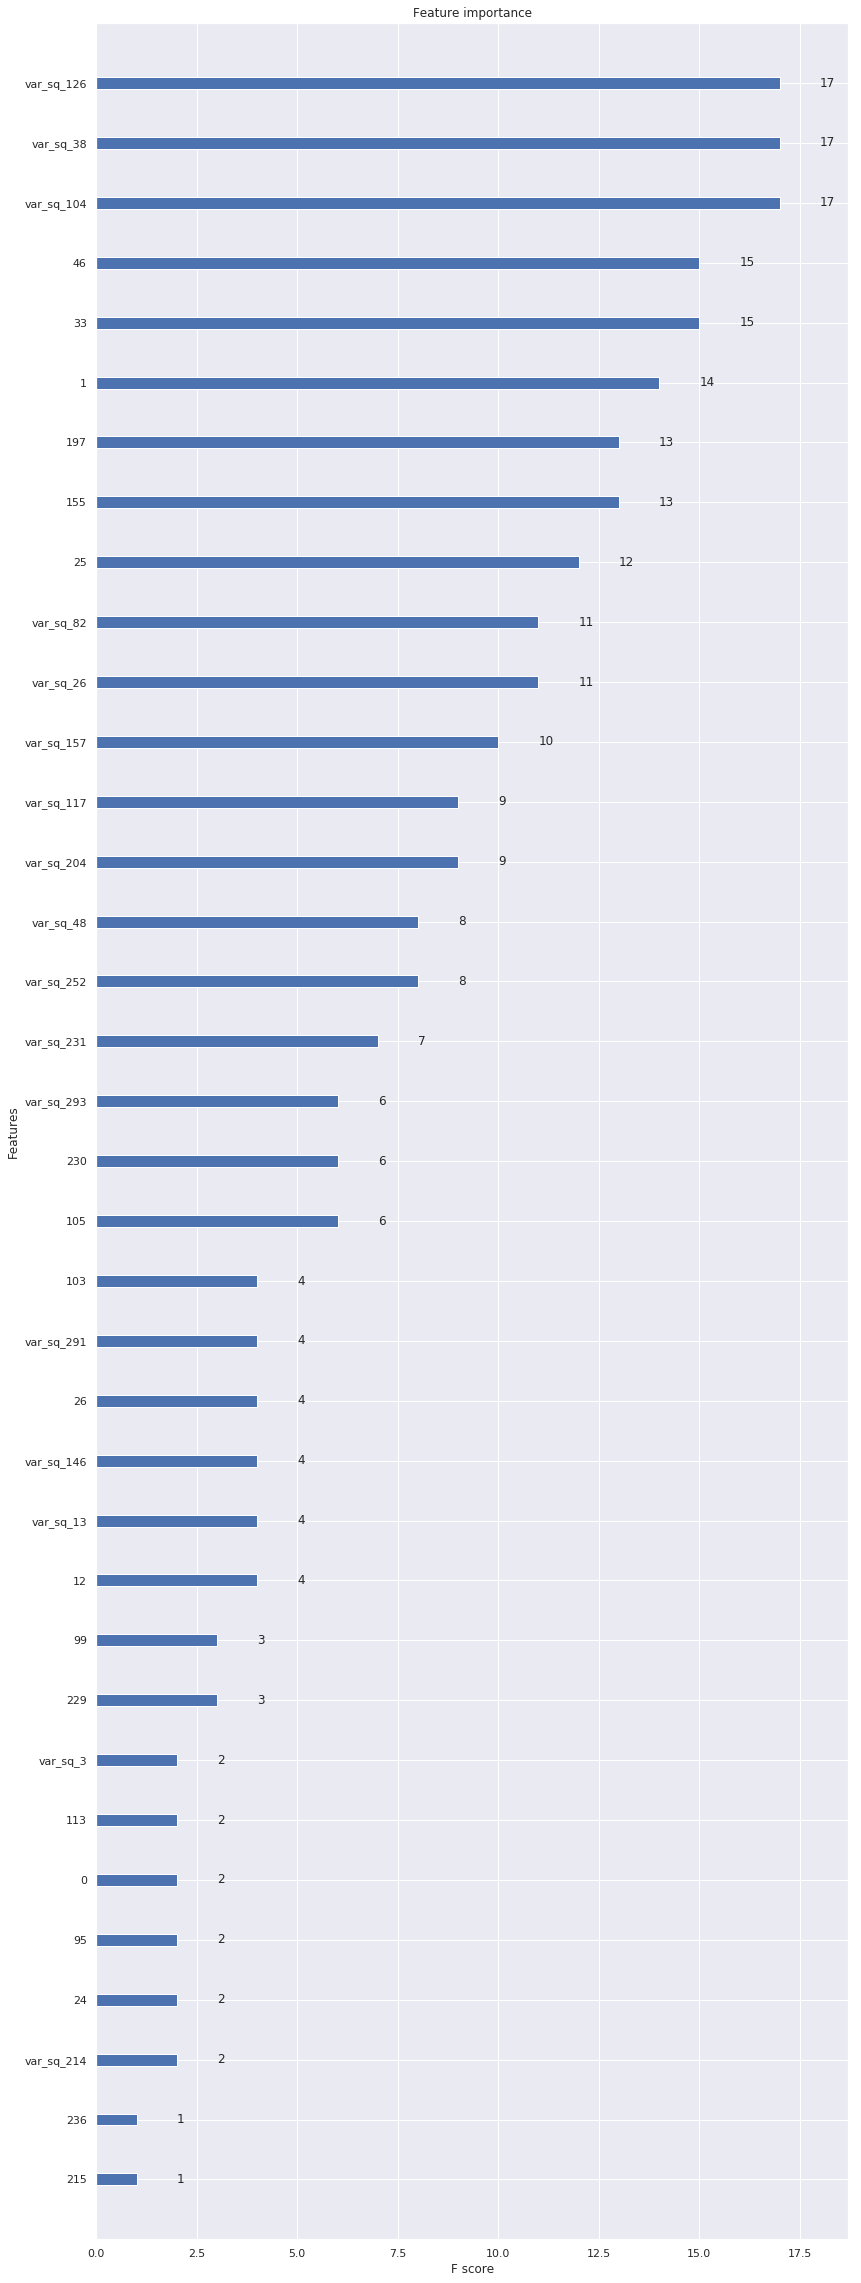

In [73]:
    fs_clf_xgb, predictions_test_fs_50_xgb = xgboost_all_purpose(X_fs_50,
                                                              y,
                                                              type_of_training =type_of_training, 
                                                              num_of_folds = num_of_folds, 
                                                              max_early_stopping= 100, 
                                                              name="fs_clf_50_xgb")

In [74]:
clf_stats_df

clf_name  F1-score  auc-score
0         clf_xgb  0.612683   0.666667
1  fs_clf_100_xgb  0.681754   0.695988
2   fs_clf_50_xgb  0.702886   0.688657

In [75]:
if untuned_model_train_flag == True:
    gc.collect();
    submission = pd.read_csv('../input/sample_submission.csv')
    submission['target'] = predictions_test_xgb
    submission.to_csv('clf_xgb.csv', index=False)


if feature_selection_flag == True:
    gc.collect();
    submission = pd.read_csv('../input/sample_submission.csv')
    submission['target'] = predictions_test_fs_100_xgb
    submission.to_csv('fs_100_clf_xgb.csv', index=False)
    
    gc.collect();
    submission = pd.read_csv('../input/sample_submission.csv')
    submission['target'] = predictions_test_fs_50_xgb
    submission.to_csv('fs_50_clf_xgb.csv', index=False)

## Conclusion
<a id="conclusion"></a>
We can see from EDA and ML Modeling that class #1 is very unbalanced and difficult to identified and classified.

_________________________________________
*I would be happy if my kernel helped you understand this problem and the data better.
if this kernel is helpful to you a thumb up or follow would be much appreciated!*